In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Tamil dataset ===
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv:
Total samples: 6779
Average text length (characters): 112.55
Average word count: 14.69
Max text length: 280
Min text length: 1
Text length distribution saved as 'tamil_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv...
Preprocessing Tamil training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    3890
1.0    2889
Name: count, dtype: int64
Class distribution plot saved as 'tamil_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model (extracting combined features and fitting SVM)...


Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_ta_l1.csv...
Preprocessing Tamil test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7807

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       596
         1.0       0.81      0.71      0.76       539

    accuracy                           0.78      1135
   macro avg       0.79      0.78      0.78      1135
weighted avg       0.79      0.78      0.78      1135

Confusion matrix saved as 'tamil_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'tamil_test_predictions.csv'
Saving model to tamil_sentiment_model.pkl...
Model saved successfully to tamil_sentiment_model.pkl
Loading model from tamil_sentiment_model.pkl...
Model loaded successfully

=== Example: Inference on single text ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:
Original Text: இது ஒரு நல்ல படம்
Processed Text: இது ஒரு நல்ல படம்
Predicted Label (Class): 0.0
Predicted Label (Value): 0.0
Confidence: 0.9387

=== Example: Inference on text file ===

=== Example: Using test file for inference ===
Extracted sample texts to extracted_tamil_texts.txt
Reading texts from extracted_tamil_texts.txt...
Found 10 texts in file
Preprocessing Tamil texts...
Making predictions...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predictions saved to tamil_sample_predictions.csv

Prediction Summary:
predicted_label_class
0.0    8
1.0    2
Name: count, dtype: int64


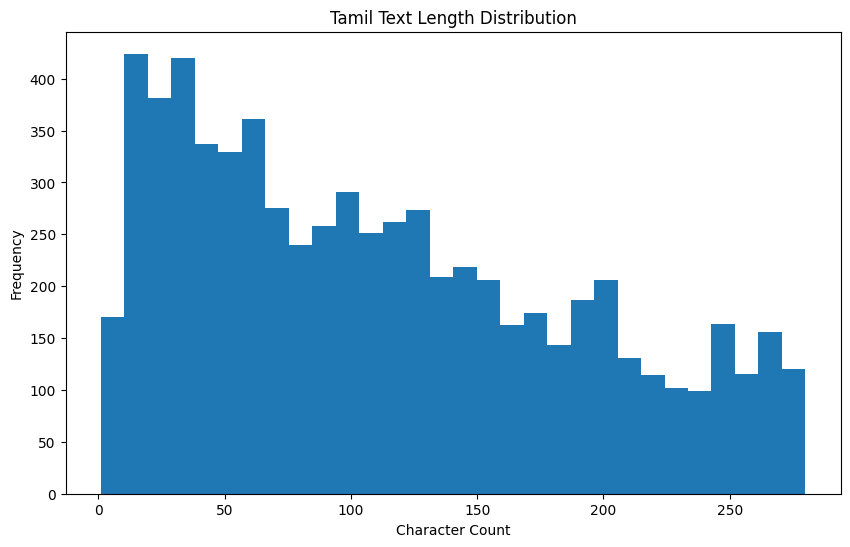

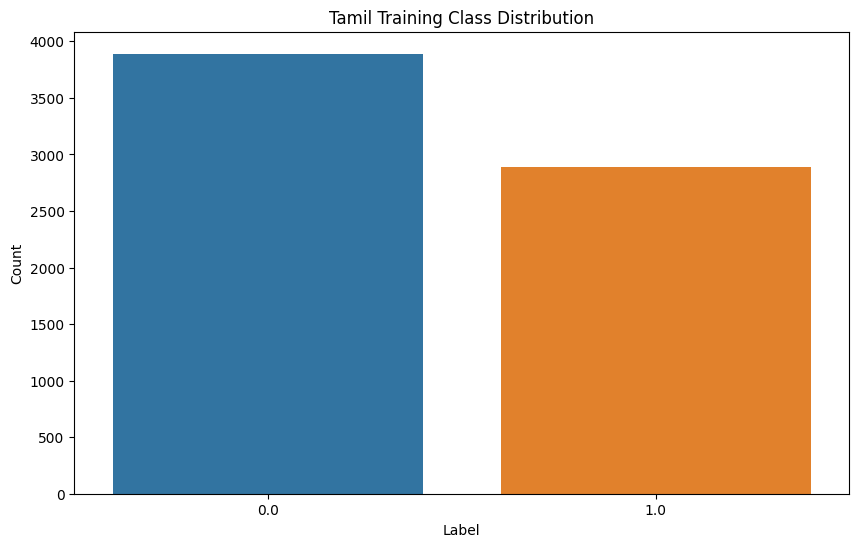

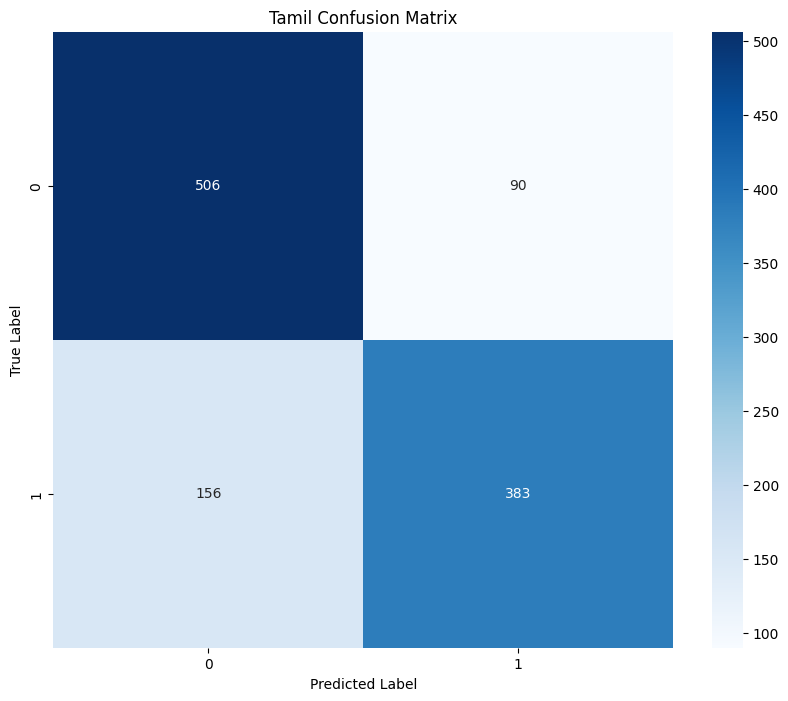

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Tamil text without specialized Tamil libraries (from first code)
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Tamil-specific cleaning (preserve Tamil characters)
    # Tamil Unicode range: \u0B80-\u0BFF
    # Keep Tamil characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    
    # Simple tokenization approach for Tamil using whitespace
    # This isn't as sophisticated as language-specific tokenizers but works as a fallback
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings

class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if it's not already
        texts = X if isinstance(X, list) else X.tolist()
        
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings
# Function to calculate majority vote for Tamil dataset
def majority_vote(row):
    # Extract annotation columns for Tamil dataset
    annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_combined_classifier(train_file, test_file=None):
    """
    Train a Tamil text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Tamil Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Tamil
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and Bag of Words
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                # Optimized for Tamil with character n-grams
                ('vectorizer', CountVectorizer(
                    max_features=15000,
                    ngram_range=(1, 3),
                    min_df=1,
                    max_df=0.95,
                    analyzer='char_wb'  # Character n-grams with word boundaries, better for Tamil
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Tamil's feature richness
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text with Tamil-specific preprocessing
            print("Preprocessing Tamil test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Tamil Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Tamil data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add extra function to analyze Tamil dataset characteristics
def analyze_hindi_dataset(file_path):
    """
    Analyze Tamil dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text with Tamil-specific preprocessing
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Tamil Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None


# Function to save the trained model
def save_model(model, model_file):
    """
    Save the trained model to disk using pickle
    
    Args:
        model: Trained classifier pipeline
        model_file: Path to save the model
    """
    import pickle
    try:
        print(f"Saving model to {model_file}...")
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved successfully to {model_file}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model
def load_model(model_file):
    """
    Load a trained model from disk
    
    Args:
        model_file: Path to the saved model
        
    Returns:
        Loaded model
    """
    import pickle
    try:
        print(f"Loading model from {model_file}...")
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a single text input
def predict_single_text(model, text):
    """
    Use a trained model to make prediction on a single Tamil text
    
    Args:
        model: Trained classifier pipeline
        text: Tamil text string
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        print("\nPrediction Results:")
        print(f"Original Text: {text}")
        print(f"Processed Text: {processed_text}")
        print(f"Predicted Label (Class): {prediction_class}")
        print(f"Predicted Label (Value): {prediction_value}")
        print(f"Confidence: {confidence:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a text file (one text per line)
def predict_from_text_file(model, input_file, output_file=None):
    """
    Use a trained model to make predictions on texts from a file
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to text file (one text per line)
        output_file: Path to save predictions (optional)
        
    Returns:
        DataFrame with predictions
    """
    try:
        texts = []
        
        # Read texts from file
        print(f"Reading texts from {input_file}...")
        with open(input_file, 'r', encoding='utf-8') as f:
            for line in f:
                text = line.strip()
                if text:  # Skip empty lines
                    texts.append(text)
        
        print(f"Found {len(texts)} texts in file")
        
        # Create DataFrame
        df = pd.DataFrame({'text': texts})
        
        # Preprocess texts
        print("Preprocessing Tamil texts...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        df['predicted_label_class'] = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        df['confidence'] = np.max(probabilities, axis=1)
        
        # Convert string predictions to float values
        df['predicted_label_value'] = df['predicted_label_class'].astype(float)
        
        # Save results if output file is specified
        if output_file:
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
        
        # Print summary
        print("\nPrediction Summary:")
        print(df['predicted_label_class'].value_counts())
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv"  # Your Tamil training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l1.csv"     # Your Tamil test file
    model_file = "hindi_sentiment_model.pkl"  # File to save model
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Tamil dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_combined_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, model_file)
    
    # Load the model (in a real scenario, this would be in a separate script)
    loaded_model = load_model(model_file)
    
    if loaded_model is not None:
        # Example 1: Inference on a single text
        print("\n=== Example: Inference on single text ===")
        sample_text = "இது ஒரு நல்ல படம்"  # "This is a good movie" in Tamil
        result = predict_single_text(loaded_model, sample_text)
        
        # Example 2: Inference on a text file
        print("\n=== Example: Inference on text file ===")
        # Assuming you have a text file with one Tamil text per line
        sample_text_file = "sample_hindi_texts.txt"  # You'd need to create this
        output_file = "hindi_text_predictions.csv"
        
        # Uncomment the following line when you have a text file:
        # df_predictions = predict_from_text_file(loaded_model, sample_text_file, output_file)
        
        # Alternative: If you want to use the test file as a source of texts:
        print("\n=== Example: Using test file for inference ===")
        test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
        sample_texts_file = "extracted_hindi_texts.txt"
        
        # Extract texts to a file
        with open(sample_texts_file, 'w', encoding='utf-8') as f:
            for text in test_df['text'].head(10):  # Just use first 10 texts as an example
                f.write(f"{text}\n")
        
        print(f"Extracted sample texts to {sample_texts_file}")
        df_predictions = predict_from_text_file(loaded_model, sample_texts_file, "hindi_sample_predictions.csv")





Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Tamil dataset ===
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_ta_l2.csv:
Total samples: 6778
Average text length (characters): 112.56
Average word count: 14.69
Max text length: 280
Min text length: 1
Text length distribution saved as 'tamil_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_ta_l2.csv...
Preprocessing Tamil training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
1.0    3520
0.0    3258
Name: count, dtype: int64
Class distribution plot saved as 'tamil_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model (extracting combined features and fitting SVM)...


Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_ta_l2.csv...
Preprocessing Tamil test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7759

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       487
         1.0       0.83      0.77      0.80       648

    accuracy                           0.78      1135
   macro avg       0.78      0.78      0.78      1135
weighted avg       0.78      0.78      0.78      1135

Confusion matrix saved as 'tamil_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'tamil_test_predictions.csv'
Saving model to tamil_sentiment_model_2.pkl...
Model saved successfully to tamil_sentiment_model_2.pkl
Loading model from tamil_sentiment_model_2.pkl...
Model loaded successfully

=== Example: Inference on single text ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:
Original Text: இது ஒரு நல்ல படம்
Processed Text: இது ஒரு நல்ல படம்
Predicted Label (Class): 0.0
Predicted Label (Value): 0.0
Confidence: 0.7116

=== Example: Inference on text file ===

=== Example: Using test file for inference ===
Extracted sample texts to extracted_tamil_texts.txt
Reading texts from extracted_tamil_texts.txt...
Found 10 texts in file
Preprocessing Tamil texts...
Making predictions...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predictions saved to tamil_sample_predictions.csv

Prediction Summary:
predicted_label_class
0.0    8
1.0    2
Name: count, dtype: int64


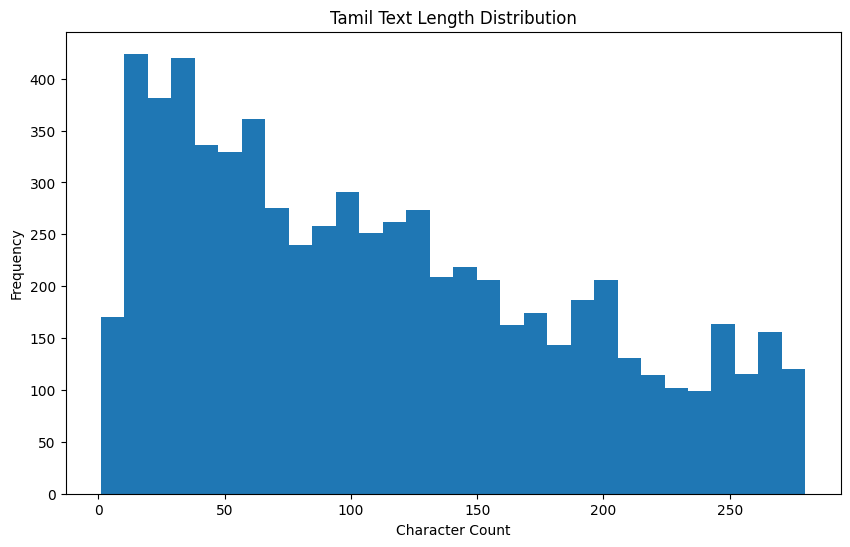

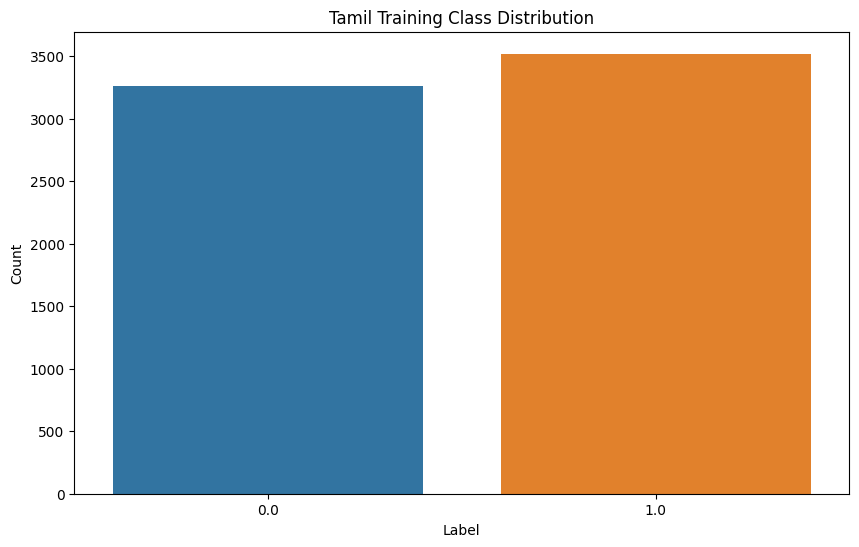

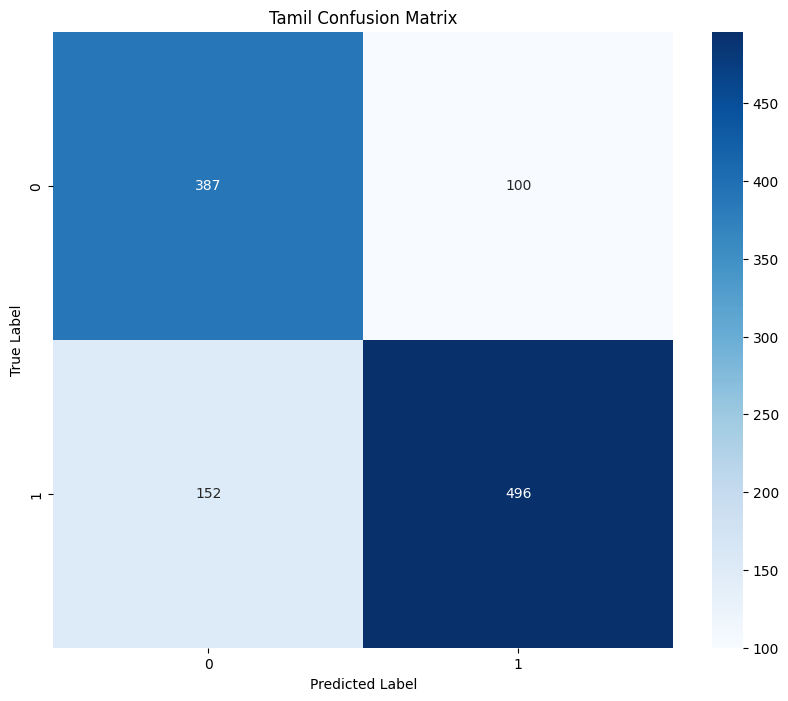

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Tamil text without specialized Tamil libraries (from first code)
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Tamil-specific cleaning (preserve Tamil characters)
    # Tamil Unicode range: \u0B80-\u0BFF
    # Keep Tamil characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    
    # Simple tokenization approach for Tamil using whitespace
    # This isn't as sophisticated as language-specific tokenizers but works as a fallback
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if it's not already
        texts = X if isinstance(X, list) else X.tolist()
        
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Function to calculate majority vote for Tamil dataset
def majority_vote(row):
    # Extract annotation columns for Tamil dataset
    annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_combined_classifier(train_file, test_file=None):
    """
    Train a Tamil text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Tamil Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Tamil
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and Bag of Words
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                # Optimized for Tamil with character n-grams
                ('vectorizer', CountVectorizer(
                    max_features=15000,
                    ngram_range=(1, 3),
                    min_df=1,
                    max_df=0.95,
                    analyzer='char_wb'  # Character n-grams with word boundaries, better for Tamil
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Tamil's feature richness
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text with Tamil-specific preprocessing
            print("Preprocessing Tamil test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Tamil Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Tamil data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add extra function to analyze Tamil dataset characteristics
def analyze_hindi_dataset(file_path):
    """
    Analyze Tamil dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text with Tamil-specific preprocessing
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Tamil Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None


# Function to save the trained model
def save_model(model, model_file):
    """
    Save the trained model to disk using pickle
    
    Args:
        model: Trained classifier pipeline
        model_file: Path to save the model
    """
    import pickle
    try:
        print(f"Saving model to {model_file}...")
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved successfully to {model_file}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model
def load_model(model_file):
    """
    Load a trained model from disk
    
    Args:
        model_file: Path to the saved model
        
    Returns:
        Loaded model
    """
    import pickle
    try:
        print(f"Loading model from {model_file}...")
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a single text input
def predict_single_text(model, text):
    """
    Use a trained model to make prediction on a single Tamil text
    
    Args:
        model: Trained classifier pipeline
        text: Tamil text string
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        print("\nPrediction Results:")
        print(f"Original Text: {text}")
        print(f"Processed Text: {processed_text}")
        print(f"Predicted Label (Class): {prediction_class}")
        print(f"Predicted Label (Value): {prediction_value}")
        print(f"Confidence: {confidence:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a text file (one text per line)
def predict_from_text_file(model, input_file, output_file=None):
    """
    Use a trained model to make predictions on texts from a file
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to text file (one text per line)
        output_file: Path to save predictions (optional)
        
    Returns:
        DataFrame with predictions
    """
    try:
        texts = []
        
        # Read texts from file
        print(f"Reading texts from {input_file}...")
        with open(input_file, 'r', encoding='utf-8') as f:
            for line in f:
                text = line.strip()
                if text:  # Skip empty lines
                    texts.append(text)
        
        print(f"Found {len(texts)} texts in file")
        
        # Create DataFrame
        df = pd.DataFrame({'text': texts})
        
        # Preprocess texts
        print("Preprocessing Tamil texts...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        df['predicted_label_class'] = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        df['confidence'] = np.max(probabilities, axis=1)
        
        # Convert string predictions to float values
        df['predicted_label_value'] = df['predicted_label_class'].astype(float)
        
        # Save results if output file is specified
        if output_file:
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
        
        # Print summary
        print("\nPrediction Summary:")
        print(df['predicted_label_class'].value_counts())
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_ta_l2.csv"  # Your Tamil training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l2.csv"     # Your Tamil test file
    model_file = "hindi_sentiment_model_2.pkl"  # File to save model
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Tamil dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_combined_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, model_file)
    
    # Load the model (in a real scenario, this would be in a separate script)
    loaded_model = load_model(model_file)
    
    if loaded_model is not None:
        # Example 1: Inference on a single text
        print("\n=== Example: Inference on single text ===")
        sample_text = "இது ஒரு நல்ல படம்"  # "This is a good movie" in Tamil
        result = predict_single_text(loaded_model, sample_text)
        
        # Example 2: Inference on a text file
        print("\n=== Example: Inference on text file ===")
        # Assuming you have a text file with one Tamil text per line
        sample_text_file = "sample_hindi_texts.txt"  # You'd need to create this
        output_file = "hindi_text_predictions.csv"
        
        # Uncomment the following line when you have a text file:
        # df_predictions = predict_from_text_file(loaded_model, sample_text_file, output_file)
        
        # Alternative: If you want to use the test file as a source of texts:
        print("\n=== Example: Using test file for inference ===")
        test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
        sample_texts_file = "extracted_hindi_texts.txt"
        
        # Extract texts to a file
        with open(sample_texts_file, 'w', encoding='utf-8') as f:
            for text in test_df['text'].head(10):  # Just use first 10 texts as an example
                f.write(f"{text}\n")
        
        print(f"Extracted sample texts to {sample_texts_file}")
        df_predictions = predict_from_text_file(loaded_model, sample_texts_file, "hindi_sample_predictions.csv")



Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully

=== Analyzing Tamil dataset ===
Dataset statistics for /kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv:
Total samples: 6779
Average text length (characters): 112.55
Average word count: 14.69
Max text length: 280
Min text length: 1
Text length distribution saved as 'tamil_text_length_distribution.png'
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv...
Preprocessing Tamil training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
1.0    4381
0.0    2398
Name: count, dtype: int64
Class distribution plot saved as 'tamil_training_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model (extracting combined features and fitting SVM)...


Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Model training complete!

Reading test data from /kaggle/input/capstone/uli_dataset-main/testing/test_ta_l3.csv...
Preprocessing Tamil test text...
Calculating majority vote for test labels...
Making predictions on test data...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.8599

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81       370
         1.0       0.92      0.89      0.91       765

    accuracy                           0.87      1135
   macro avg       0.85      0.87      0.86      1135
weighted avg       0.88      0.87      0.88      1135

Confusion matrix saved as 'tamil_confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'tamil_test_predictions.csv'
Saving model to tamil_sentiment_model_3.pkl...
Model saved successfully to tamil_sentiment_model_3.pkl
Loading model from tamil_sentiment_model_3.pkl...
Model loaded successfully

=== Example: Inference on single text ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:
Original Text: இது ஒரு நல்ல படம்
Processed Text: இது ஒரு நல்ல படம்
Predicted Label (Class): 0.0
Predicted Label (Value): 0.0
Confidence: 0.9433

=== Example: Inference on text file ===

=== Example: Using test file for inference ===
Extracted sample texts to extracted_tamil_texts.txt
Reading texts from extracted_tamil_texts.txt...
Found 10 texts in file
Preprocessing Tamil texts...
Making predictions...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Predictions saved to tamil_sample_predictions.csv

Prediction Summary:
predicted_label_class
1.0    5
0.0    5
Name: count, dtype: int64


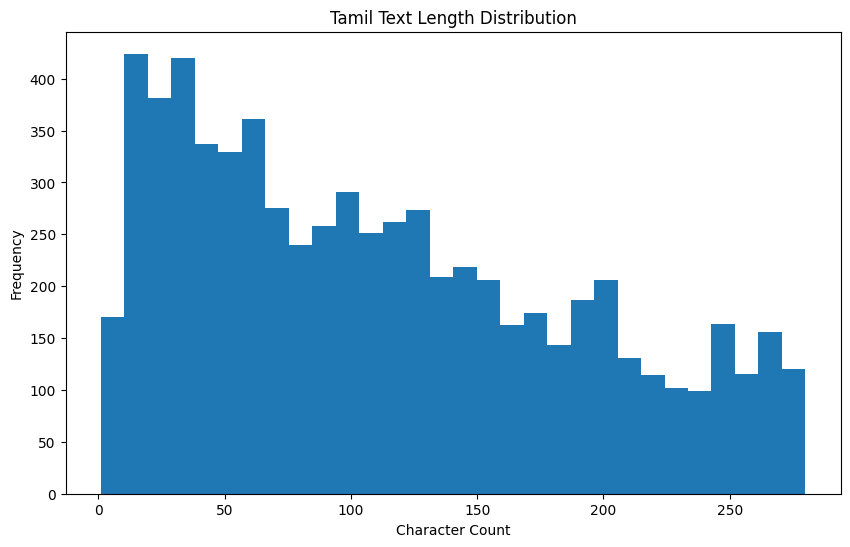

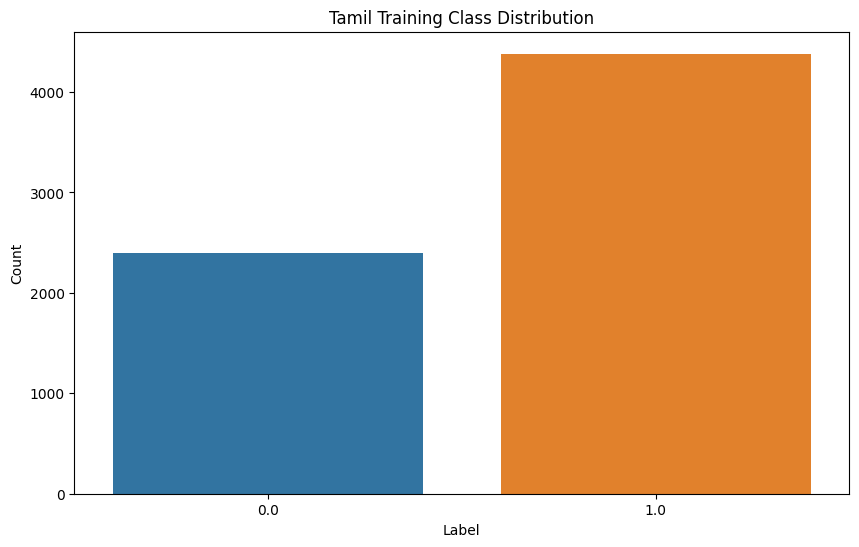

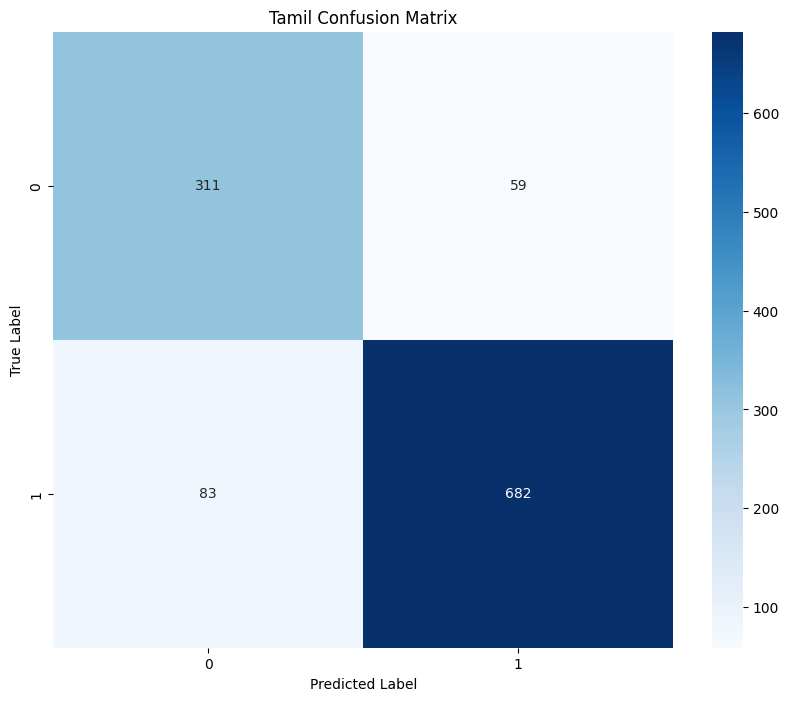

In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Tamil text without specialized Tamil libraries (from first code)
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Tamil-specific cleaning (preserve Tamil characters)
    # Tamil Unicode range: \u0B80-\u0BFF
    # Keep Tamil characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    
    # Simple tokenization approach for Tamil using whitespace
    # This isn't as sophisticated as language-specific tokenizers but works as a fallback
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if it's not already
        texts = X if isinstance(X, list) else X.tolist()
        
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Function to calculate majority vote for Tamil dataset
def majority_vote(row):
    # Extract annotation columns for Tamil dataset
    annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_hindi_combined_classifier(train_file, test_file=None):
    """
    Train a Tamil text classifier using SVM with combined Sentence Transformer 
    and Bag of Words features.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_hindi_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Tamil Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('hindi_training_class_distribution.png')
        print("Class distribution plot saved as 'hindi_training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create pipeline with combined feature extractors optimized for Tamil
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        
        # Feature union pipeline combining Sentence Transformers and Bag of Words
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                # Optimized for Tamil with character n-grams
                ('vectorizer', CountVectorizer(
                    max_features=15000,
                    ngram_range=(1, 3),
                    min_df=1,
                    max_df=0.95,
                    analyzer='char_wb'  # Character n-grams with word boundaries, better for Tamil
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Tamil's feature richness
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model (extracting combined features and fitting SVM)...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text with Tamil-specific preprocessing
            print("Preprocessing Tamil test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_hindi_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Tamil Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('hindi_confusion_matrix.png')
            print("Confusion matrix saved as 'hindi_confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('hindi_test_predictions.csv', index=False)
            print("Test predictions saved to 'hindi_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Tamil data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add extra function to analyze Tamil dataset characteristics
def analyze_hindi_dataset(file_path):
    """
    Analyze Tamil dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text with Tamil-specific preprocessing
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Tamil Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None


# Function to save the trained model
def save_model(model, model_file):
    """
    Save the trained model to disk using pickle
    
    Args:
        model: Trained classifier pipeline
        model_file: Path to save the model
    """
    import pickle
    try:
        print(f"Saving model to {model_file}...")
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved successfully to {model_file}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model
def load_model(model_file):
    """
    Load a trained model from disk
    
    Args:
        model_file: Path to the saved model
        
    Returns:
        Loaded model
    """
    import pickle
    try:
        print(f"Loading model from {model_file}...")
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a single text input
def predict_single_text(model, text):
    """
    Use a trained model to make prediction on a single Tamil text
    
    Args:
        model: Trained classifier pipeline
        text: Tamil text string
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction_class = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Convert string prediction back to float value
        prediction_value = float(prediction_class)
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'predicted_label_class': prediction_class,
            'predicted_label_value': prediction_value,
            'confidence': confidence
        }
        
        print("\nPrediction Results:")
        print(f"Original Text: {text}")
        print(f"Processed Text: {processed_text}")
        print(f"Predicted Label (Class): {prediction_class}")
        print(f"Predicted Label (Value): {prediction_value}")
        print(f"Confidence: {confidence:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a text file (one text per line)
def predict_from_text_file(model, input_file, output_file=None):
    """
    Use a trained model to make predictions on texts from a file
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to text file (one text per line)
        output_file: Path to save predictions (optional)
        
    Returns:
        DataFrame with predictions
    """
    try:
        texts = []
        
        # Read texts from file
        print(f"Reading texts from {input_file}...")
        with open(input_file, 'r', encoding='utf-8') as f:
            for line in f:
                text = line.strip()
                if text:  # Skip empty lines
                    texts.append(text)
        
        print(f"Found {len(texts)} texts in file")
        
        # Create DataFrame
        df = pd.DataFrame({'text': texts})
        
        # Preprocess texts
        print("Preprocessing Tamil texts...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        df['predicted_label_class'] = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        df['confidence'] = np.max(probabilities, axis=1)
        
        # Convert string predictions to float values
        df['predicted_label_value'] = df['predicted_label_class'].astype(float)
        
        # Save results if output file is specified
        if output_file:
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
        
        # Print summary
        print("\nPrediction Summary:")
        print(df['predicted_label_class'].value_counts())
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv"  # Your Tamil training file
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l3.csv"     # Your Tamil test file
    model_file = "hindi_sentiment_model_3.pkl"  # File to save model
    
    # Optional: Analyze dataset characteristics
    print("\n=== Analyzing Tamil dataset ===")
    analyze_hindi_dataset(train_file)
    
    # Train the model and evaluate on test data
    model, macro_f1, report = train_hindi_combined_classifier(train_file, test_file)
    
    # Save the trained model
    if model is not None:
        save_model(model, model_file)
    
    # Load the model (in a real scenario, this would be in a separate script)
    loaded_model = load_model(model_file)
    
    if loaded_model is not None:
        # Example 1: Inference on a single text
        print("\n=== Example: Inference on single text ===")
        sample_text = "இது ஒரு நல்ல படம்"  # "This is a good movie" in Tamil
        result = predict_single_text(loaded_model, sample_text)
        
        # Example 2: Inference on a text file
        print("\n=== Example: Inference on text file ===")
        # Assuming you have a text file with one Tamil text per line
        sample_text_file = "sample_hindi_texts.txt"  # You'd need to create this
        output_file = "hindi_text_predictions.csv"
        
        # Uncomment the following line when you have a text file:
        # df_predictions = predict_from_text_file(loaded_model, sample_text_file, output_file)
        
        # Alternative: If you want to use the test file as a source of texts:
        print("\n=== Example: Using test file for inference ===")
        test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
        sample_texts_file = "extracted_hindi_texts.txt"
        
        # Extract texts to a file
        with open(sample_texts_file, 'w', encoding='utf-8') as f:
            for text in test_df['text'].head(10):  # Just use first 10 texts as an example
                f.write(f"{text}\n")
        
        print(f"Extracted sample texts to {sample_texts_file}")
        df_predictions = predict_from_text_file(loaded_model, sample_texts_file, "hindi_sample_predictions.csv")


In [ ]:
import pandas as pd
import numpy as np
import re
import csv
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import torch
from sentence_transformers import SentenceTransformer

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Function to preprocess Tamil text without specialized Tamil libraries (from first code)
def preprocess_hindi_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Handle Tamil-specific cleaning (preserve Tamil characters)
    # Tamil Unicode range: \u0B80-\u0BFF
    # Keep Tamil characters, numerals, spaces, and remove others
    text = re.sub(r'[^\u0B80-\u0BFF0-9\s]', '', text)
    
    # Simple tokenization approach for Tamil using whitespace
    # This isn't as sophisticated as language-specific tokenizers but works as a fallback
    text = ' '.join(text.split())
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Initialize Sentence Transformer model
print("Loading Sentence Transformer model...")
sentence_model = SentenceTransformer('google/muril-base-cased', device=device)
print(f"Sentence Transformer model loaded successfully")

# Custom transformer for Sentence Transformer embeddings
class SentenceTransformerFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, model=None, batch_size=32):
        """
        Extract Sentence Transformer embeddings for text classification.
        
        Args:
            model: Pre-trained Sentence Transformer model
            batch_size: Batch size for processing
        """
        self.model = model
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        # Nothing to fit, just initialize
        if self.model is None:
            self.model = sentence_model
        return self
    
    def transform(self, X):
        """Transform texts to sentence embeddings"""
        # Convert to list if it's not already
        texts = X if isinstance(X, list) else X.tolist()
        
        # Use sentence-transformers' built-in batching
        embeddings = self.model.encode(
            texts, 
            batch_size=self.batch_size, 
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

# Function to calculate majority vote for Tamil dataset
def majority_vote(row):
    # Extract annotation columns for Tamil dataset
    annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_hindi_classifier(l1_file, l3_file, test_l1_file=None, test_l3_file=None):
    """
    Combine L1 and L3 datasets, train a model, and evaluate.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        test_l1_file: Path to the L1 test CSV file (optional)
        test_l3_file: Path to the L3 test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = pd.read_csv(l1_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = pd.read_csv(l3_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote, axis=1)  # Using the existing majority_vote function
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                   (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_hindi_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution.png')
        print("Class distribution plot saved as 'combined_class_distribution.png'")
        
        # Prepare training data
        X_train = merged_df['processed_text']
        y_train = merged_df['final_label']  # Using the combined label
        
        # Create feature pipeline with Sentence Transformer embeddings and Bag of Words
        print("\nCreating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...")
        
        feature_union = FeatureUnion([
            ('sentence_embeddings', Pipeline([
                ('sentence_transformer', SentenceTransformerFeatures(
                    model=sentence_model,
                    batch_size=32
                )),
                ('scaler_sbert', StandardScaler())
            ])),
            ('bag_of_words', Pipeline([
                # Optimized for Tamil with character n-grams
                ('vectorizer', CountVectorizer(
                    max_features=15000,
                    ngram_range=(1, 3),
                    min_df=1,
                    max_df=0.95,
                    analyzer='char_wb'  # Character n-grams with word boundaries, better for Tamil
                )),
                ('tfidf', TfidfTransformer())
            ]))
        ])
        
        # Full pipeline with combined features and SVM
        pipeline = Pipeline([
            ('features', feature_union),
            ('classifier', SVC(
                C=5.0,                  # Less regularization for Tamil's feature richness
                kernel='rbf',           # Radial basis function kernel
                gamma='scale',          # Scale gamma based on feature variance
                class_weight='balanced', # Handle class imbalance
                probability=True,       # Enable probability estimates
                random_state=42
            ))
        ])
        
        # Train the model
        print("Training the model on combined L1 and L3 data...")
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # If test files are provided, evaluate on combined test data
        if test_l1_file and test_l3_file:
            # Read the L1 test CSV file
            print(f"\nReading L1 test data from {test_l1_file}...")
            l1_test_df = pd.read_csv(test_l1_file, quoting=csv.QUOTE_MINIMAL)
            
            # Read the L3 test CSV file
            print(f"Reading L3 test data from {test_l3_file}...")
            l3_test_df = pd.read_csv(test_l3_file, quoting=csv.QUOTE_MINIMAL)
            
            # Ensure both test datasets have a unique ID
            if 'id' not in l1_test_df.columns:
                l1_test_df['id'] = range(len(l1_test_df))
            if 'id' not in l3_test_df.columns:
                l3_test_df['id'] = range(len(l3_test_df))
            
            # Calculate majority vote for test datasets
            l1_test_df['l1_label'] = l1_test_df.apply(majority_vote, axis=1)
            l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_l3, axis=1)
            
            # Extract essential columns from test datasets
            l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
            l3_test_subset = l3_test_df[['id', 'l3_label']]
            
            # Merge test datasets
            print("Merging L1 and L3 test datasets...")
            merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
            
            # Determine final test label
            merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                           (merged_test_df['l3_label'] == 1.0)).astype(int)
            
            # Preprocess test text
            merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_hindi_text)
            
            # Prepare test data
            X_test = merged_test_df['processed_text']
            y_test = merged_test_df['final_label']
            
            # Make predictions
            print("Making predictions on combined test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Combined Test Data Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('combined_test_confusion_matrix.png')
            print("Confusion matrix saved as 'combined_test_confusion_matrix.png'")
            
            # Save sample predictions
            results_df = pd.DataFrame({
                'id': merged_test_df['id'],
                'text': X_test.values,
                'l1_label': merged_test_df['l1_label'],
                'l3_label': merged_test_df['l3_label'],
                'true_combined_label': y_test.values,
                'predicted_label': y_pred,
                'prediction_confidence': np.max(pipeline.predict_proba(X_test), axis=1)
            })
            results_df.to_csv('combined_test_predictions.csv', index=False)
            print("Test predictions saved to 'combined_test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test files provided. Model trained successfully on combined data.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new Tamil data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column with Tamil-specific preprocessing
        print("Preprocessing Tamil text...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence
        df['prediction_confidence'] = np.max(probabilities, axis=1)
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Add extra function to analyze Tamil dataset characteristics
def analyze_hindi_dataset(file_path):
    """
    Analyze Tamil dataset characteristics after preprocessing
    
    Args:
        file_path: Path to the CSV file
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text with Tamil-specific preprocessing
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Get statistics
        text_lengths = df['processed_text'].str.len()
        word_counts = df['processed_text'].str.split().str.len()
        
        print(f"Dataset statistics for {file_path}:")
        print(f"Total samples: {len(df)}")
        print(f"Average text length (characters): {text_lengths.mean():.2f}")
        print(f"Average word count: {word_counts.mean():.2f}")
        print(f"Max text length: {text_lengths.max()}")
        print(f"Min text length: {text_lengths.min()}")
        
        # Plot text length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(text_lengths, bins=30)
        plt.title('Tamil Text Length Distribution')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.savefig('hindi_text_length_distribution.png')
        print("Text length distribution saved as 'hindi_text_length_distribution.png'")
        
        return df
    
    except Exception as e:
        print(f"Error: {e}")
        return None


# Function to save the trained model
def save_model(model, model_file):
    """
    Save the trained model to disk using pickle
    
    Args:
        model: Trained classifier pipeline
        model_file: Path to save the model
    """
    import pickle
    try:
        print(f"Saving model to {model_file}...")
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved successfully to {model_file}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model
def load_model(model_file):
    """
    Load a trained model from disk
    
    Args:
        model_file: Path to the saved model
        
    Returns:
        Loaded model
    """
    import pickle
    try:
        print(f"Loading model from {model_file}...")
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a single text input
def predict_combined_single_text(model, text):
    """
    Use a trained combined model to make prediction on a single Tamil text
    
    Args:
        model: Trained classifier pipeline for combined L1 and L3 data
        text: Tamil text string
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Preprocess the text
        processed_text = preprocess_hindi_text(text)
        
        # Make prediction
        prediction = model.predict([processed_text])[0]
        
        # Get probability estimates
        probabilities = model.predict_proba([processed_text])[0]
        confidence = max(probabilities)
        
        # Interpret the combined prediction
        if prediction == 1:
            interpretation = "Potentially problematic content detected (both L1 and L3 issues)"
        else:
            interpretation = "No significant combined issues detected"
        
        result = {
            'original_text': text,
            'processed_text': processed_text,
            'prediction': prediction,
            'confidence': confidence,
            'interpretation': interpretation
        }
        
        print("\nPrediction Results:")
        print(f"Original Text: {text}")
        print(f"Processed Text: {processed_text}")
        print(f"Combined Prediction: {prediction} ({interpretation})")
        print(f"Confidence: {confidence:.4f}")
        
        return result
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to perform inference on a text file (one text per line)
def predict_from_text_file(model, input_file, output_file=None):
    """
    Use a trained model to make predictions on texts from a file
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to text file (one text per line)
        output_file: Path to save predictions (optional)
        
    Returns:
        DataFrame with predictions
    """
    try:
        texts = []
        
        # Read texts from file
        print(f"Reading texts from {input_file}...")
        with open(input_file, 'r', encoding='utf-8') as f:
            for line in f:
                text = line.strip()
                if text:  # Skip empty lines
                    texts.append(text)
        
        print(f"Found {len(texts)} texts in file")
        
        # Create DataFrame
        df = pd.DataFrame({'text': texts})
        
        # Preprocess texts
        print("Preprocessing Tamil texts...")
        df['processed_text'] = df['text'].apply(preprocess_hindi_text)
        
        # Make predictions
        print("Making predictions...")
        df['predicted_label_class'] = model.predict(df['processed_text'])
        
        # Get probability estimates
        probabilities = model.predict_proba(df['processed_text'])
        df['confidence'] = np.max(probabilities, axis=1)
        
        # Convert string predictions to float values
        df['predicted_label_value'] = df['predicted_label_class'].astype(float)
        
        # Save results if output file is specified
        if output_file:
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
        
        # Print summary
        print("\nPrediction Summary:")
        print(df['predicted_label_class'].value_counts())
        
        return df
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()
        return None




Using device: cuda
Loading Sentence Transformer model...
Sentence Transformer model loaded successfully


Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing Tamil text...

Final label class distribution:
final_label
0    3914
1    2865
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution.png'

Creating feature pipeline with Sentence Transformer embeddings, Bag of Words, and SVM classifier...
Training the model on combined L1 and L3 data...


Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Model training complete!

Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_ta_l1.csv...
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_ta_l3.csv...
Merging L1 and L3 test datasets...
Making predictions on combined test data...


Batches:   0%|          | 0/36 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.7916

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       608
           1       0.81      0.72      0.77       527

    accuracy                           0.79      1135
   macro avg       0.80      0.79      0.79      1135
weighted avg       0.80      0.79      0.79      1135

Confusion matrix saved as 'combined_test_confusion_matrix.png'


Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Test predictions saved to 'combined_test_predictions.csv'
Saving model to tamil_combined_sentiment_model.pkl...
Model saved successfully to tamil_combined_sentiment_model.pkl

=== Example: Inference with combined model on single text ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:
Original Text: இது ஒரு நல்ல படம்
Processed Text: இது ஒரு நல்ல படம்
Combined Prediction: 0 (No significant combined issues detected)
Confidence: 0.9364


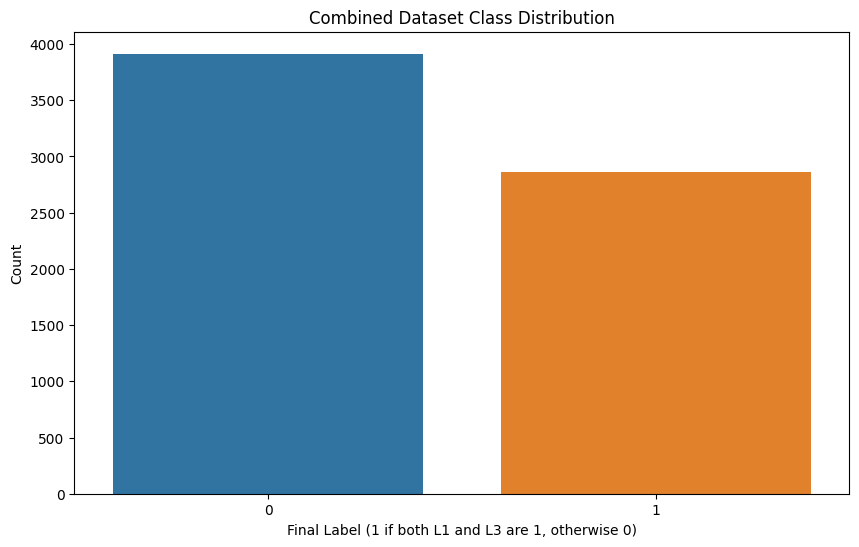

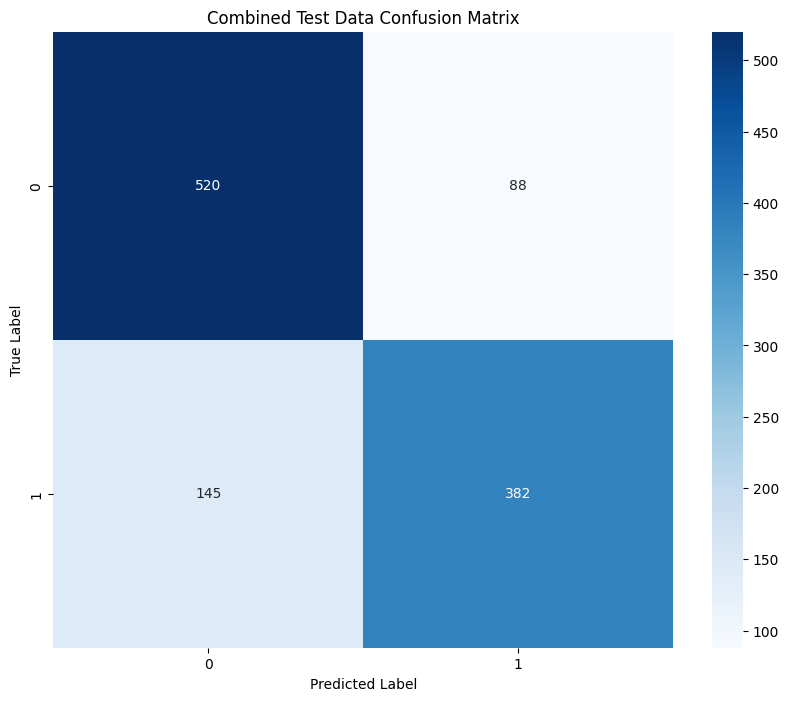

In [ ]:
if __name__ == "__main__":
    l1_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv"
    l3_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv"
    l1_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l1.csv"
    l3_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l3.csv"
    model_file = "hindi_combined_sentiment_model.pkl"
    
    # Train the combined model on L1 and L3 data
    combined_model, combined_macro_f1, combined_report = train_combined_hindi_classifier(
        l1_train_file, l3_train_file, l1_test_file, l3_test_file
    )
    
    # Save the trained model
    if combined_model is not None:
        save_model(combined_model, model_file)
    
    # Example: Inference on a single text with the combined model
    if combined_model is not None:
        print("\n=== Example: Inference with combined model on single text ===")
        sample_text = "இது ஒரு நல்ல படம்"  # "This is a good movie" in Tamil
        combined_result = predict_combined_single_text(combined_model, sample_text)